In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from datetime import datetime
import random
from sklearn.cross_validation import train_test_split
import math
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc
from statsmodels.tools import categorical

color = sns.color_palette()
%matplotlib inline

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
properties_og = pd.read_csv('properties_2016.csv')
transactions_og = pd.read_csv('train_2016_v2.csv')
train = pd.read_csv('train.csv', index_col=0)
properties = pd.read_csv('imputed.csv')
train_master = train
properties_master = properties

/Users/Patrick/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
drop_cols = [
    'fips',
    'propertycountylandusecode',
    'censustractandblock',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'assessmentyear', # same year
    'hashottuborspa',
    'year',
    'month',
    'threequarterbathnbr'
]

for col in properties_master.columns:
    if col in drop_cols:
        properties_master = properties_master.drop(col, axis=1)
        train_master = train_master.drop(col, axis=1)       

In [25]:
train_master = train_master.drop('month', axis=1)
train_master = train_master.drop('year', axis=1)

In [100]:
train_master.columns

Index(['parcelid', 'logerror', 'airconditioningtypeid', 'bathroomcnt',
       'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt',
       'propertylandusetypeid', 'regionidcounty', 'unitcnt', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'logstructuretaxvaluedollarcnt', 'loglandtaxvaluedollarcnt'],
      dtype='object')

In [5]:
def feature_importance(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.feature_importances_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

In [101]:
train_master.columns.tolist()

['parcelid',
 'logerror',
 'airconditioningtypeid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedfinishedsquarefeet',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'propertylandusetypeid',
 'regionidcounty',
 'unitcnt',
 'yearbuilt',
 'numberofstories',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'logstructuretaxvaluedollarcnt',
 'loglandtaxvaluedollarcnt']

In [6]:
train_master['structuretaxvaluedollarcnt'] = train_master['structuretaxvaluedollarcnt'].replace(to_replace= 0, value = 1)
train_master['landtaxvaluedollarcnt'] = train_master['landtaxvaluedollarcnt'].replace(to_replace= 0, value = 1)

In [7]:
train_master['logstructuretaxvaluedollarcnt'] = np.log(train_master['structuretaxvaluedollarcnt'])
train_master['loglandtaxvaluedollarcnt'] = np.log(train_master['landtaxvaluedollarcnt'])

In [111]:
train_master['fullbathcnt'] = train_master['fullbathcnt'].replace(to_replace= -1, value = 2)

In [123]:
train_master.yearbuilt[train_master.yearbuilt > -1].mean()

1968.5328701169585

In [127]:
#impute mean year built for missing values (coded as -1): 1969

train_master.yearbuilt[train_master.yearbuilt == -1] = 1969

/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


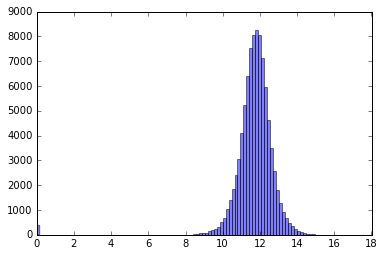

In [247]:
n, bins, patches = plt.hist(train_master.logstructuretaxvaluedollarcnt, 100, facecolor='blue', alpha=0.5)
plt.show()

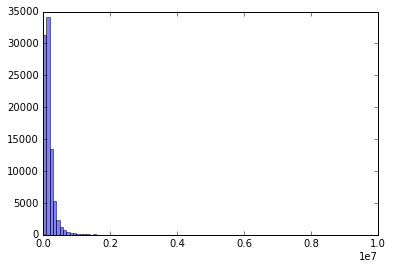

In [248]:
n, bins, patches = plt.hist(train_master.structuretaxvaluedollarcnt, 100, facecolor='blue', alpha=0.5)
plt.show()

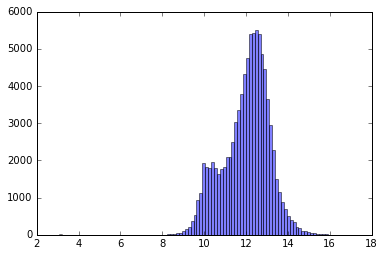

In [249]:
n, bins, patches = plt.hist(train_master.loglandtaxvaluedollarcnt, 100, facecolor='blue', alpha=0.5)
plt.show()

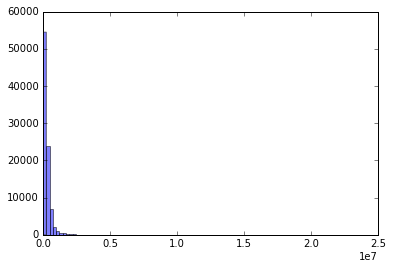

In [250]:
n, bins, patches = plt.hist(train_master.landtaxvaluedollarcnt, 100, facecolor='blue', alpha=0.5)
plt.show()

### 1) Preprocessing: Convert 64 bit floats to 32 bit and fix column name types

In [54]:
for c, dtype in zip(train_master.columns, train_master.dtypes):
    if dtype == np.float64:
        train_master[c] = train_master[c].astype(np.float32)

In [55]:
for c in properties_master.columns:
    properties_master[c]=properties_master[c].fillna(-1)
    if properties_master[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties_master[c].values))
        properties_master[c] = lbl.transform(list(properties_master[c].values))

In [56]:
train_master = transactions_og.merge(properties_master, how='left', on='parcelid')

## Gradient Boosting and XGBoost

### 1) Initialize train_y, train_xvars, feature names

In [132]:
train_y = train_master['logerror'].values
train_x = train_master.drop(['parcelid','logerror','structuretaxvaluedollarcnt', 
                             'landtaxvaluedollarcnt','taxdelinquencyyear'], axis = 1)

In [ ]:
#XGB stuff
#test_x = properties_master.drop(['parcelid'], axis = 1)
#feat_names = train_x.columns.values
#mean_y = np.mean(train_y)

In [133]:
#create the dummy matrices for each categorical variable, and add back into the X_test and X_train dfs

airconditioningtypeid_array_train_x = np.array(train_x['airconditioningtypeid'])
airconditioningtypeid_array_train_x = categorical(airconditioningtypeid_array_train_x, drop=True)

propertylandusetypeid_array_train_x = np.array(train_x['propertylandusetypeid'])
propertylandusetypeid_array_train_x = categorical(propertylandusetypeid_array_train_x, drop=True)

heatingorsystemtypeid_array_train_x = np.array(train_x['heatingorsystemtypeid'])
heatingorsystemtypeid_array_train_x = categorical(heatingorsystemtypeid_array_train_x, drop=True)

regionidcounty_array_train_x = np.array(train_x['regionidcounty'])
regionidcounty_array_train_x = categorical(regionidcounty_array_train_x, drop=True)

buildingqualitytypeid_array_train_x = np.array(train_x['buildingqualitytypeid'])
buildingqualitytypeid_array_train_x = categorical(buildingqualitytypeid_array_train_x, drop=True)

unitcnt_array_train_x = np.array(train_x['unitcnt'])
unitcnt_array_train_x = categorical(unitcnt_array_train_x, drop=True)

numberofstories_array_train_x = np.array(train_x['numberofstories'])
numberofstories_array_train_x = categorical(numberofstories_array_train_x, drop=True)

In [134]:
train_x_drop = train_x.drop(['airconditioningtypeid','heatingorsystemtypeid',
                        'propertylandusetypeid','regionidcounty','buildingqualitytypeid',
                        'unitcnt','numberofstories'], axis = 1)

In [135]:
train_xnew = np.concatenate((train_x_drop, airconditioningtypeid_array_train_x,
                         propertylandusetypeid_array_train_x,
                         heatingorsystemtypeid_array_train_x,
                         regionidcounty_array_train_x,
                         buildingqualitytypeid_array_train_x,
                         unitcnt_array_train_x,
                         numberofstories_array_train_x), axis = 1)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(train_xnew, train_y, test_size=0.2, random_state=42)

In [137]:
X_train.shape

(72220, 74)

In [223]:
#for c in X_train.dtypes[X_train.dtypes == object].index.values:
#    X_train[c] = (X_train[c] == True)

In [139]:
print('Shape train: {}\nShape test: {}'.format(X_train.shape, X_test.shape))

Shape train: (72220, 74)
Shape test: (18055, 74)


### Gradient Boosting Model

In [140]:
parameters = {'n_estimators':[40],
              'learning_rate':[0.06],
              'subsample':[.85],
              'max_depth':[7],
              'max_features':[8,9,10],
              'min_samples_split':[600]
             }


gb_reg = GradientBoostingRegressor(verbose=0,random_state=42)

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=5)  
gb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.06], 'max_features': [8, 9, 10], 'min_samples_split': [600], 'subsample': [0.85], 'n_estimators': [40], 'max_depth': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [141]:
print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_features': 9, 'min_samples_split': 600, 'subsample': 0.85, 'max_depth': 7, 'n_estimators': 40}


In [92]:
#model 3: dummy variables, no interpretability, more cv

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_features': 8, 'min_samples_split': 600, 'subsample': 0.85, 'max_depth': 7, 'n_estimators': 40}


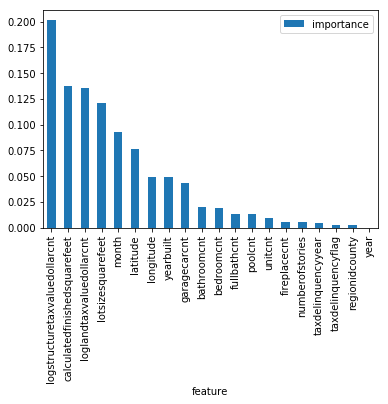

In [38]:
#model 2: more cv

feature_importance(gb_cv.best_estimator_, X_train.columns)

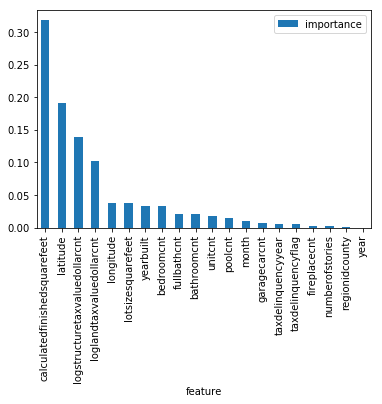

In [15]:
### model 1: limited cv
feature_importance(gb_cv.best_estimator_, X_train.columns)

In [20]:
plot.savefig('feature_importance_gbm1.png')

NameError: name 'plot' is not defined

In [142]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.068399759994235407

In [99]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.068409961572080513

In [ ]:
###Results

#1) parameters = {'learning_rate': 0.01, 'n_estimators': 20, 'max_depth': 9}
#        cv = 3
#        MAE = .068683817238

#2) parameters = {'n_estimators':[40,60],
#             'learning_rate':[0.07, 0.1],
#             'subsample':[.8,.9],
#             'max_depth':[8,9,10],
#             'max_features':[6,7],
#             'min_samples_split':[300,500,700]
#            }
#  best_params = {'learning_rate': 0.07, 
#                  'max_features': 7, 
#                  'min_samples_split': 500, 
#                  'subsample': 0.8, 
#                  'max_depth': 8, 
#                  'n_estimators': 40}
#         cv = 5
#         MAE = .068389338654760323

#3) model with categorical variables as dummies (including numbath, numbed)

#  parameters = {'n_estimators':[40,50],
#              'learning_rate':[0.06, 0.07],
#              'subsample':[.8,.85],
#              'max_depth':[7,8],
#              'max_features':[7,8],
#              'min_samples_split':[400,500,600]
#             }
#  best_params = {'learning_rate': 0.06, 
#                  'max_features': 8, 
#                  'min_samples_split': 600, 
#                  'subsample': 0.85, 
#                  'max_depth': 7, 
#                  'n_estimators': 40}
#         cv = 5
#         MAE = 0.068436882188459225

#4) model with categorical variables as dummies (including numbath, numbed)

#  parameters = {'n_estimators':[40],
#              'learning_rate':[0.06],
#              'subsample':[.85],
#              'max_depth':[7],
#              'max_features':[12,13,14,15],
#              'min_samples_split':[600]
#             }
#  best_params = {'learning_rate': 0.06, 
#                  'max_features': 14, 
#                  'min_samples_split': 600, 
#                  'subsample': 0.85, 
#                  'max_depth': 7, 
#                  'n_estimators': 40}
#         cv = 5
#         MAE = 0.068409961572080513

#5) model with categorical variables as dummies 
#    (numbath, numbed, totalbath, yearbuilt are numeric continuous)

#  parameters = {'n_estimators':[40],
#              'learning_rate':[0.06],
#              'subsample':[.85],
#              'max_depth':[7],
#              'max_features':[8,9,10],
#              'min_samples_split':[600]
#             }
#  best_params = {'learning_rate': 0.06, 
#              'max_features': 9, 
#              'min_samples_split': 600, 
#              'subsample': 0.85, 
#              'max_depth': 7, 
#              'n_estimators': 40}
#         cv = 5
#         MAE = 0.068399759994235407




### XGBoost

In [ ]:
#Reminder: X_train, X_test, y_train, y_test = train_test_split(train_xnew, train_y, test_size=0.2, random_state=42)

### 2) Set parameters

In [148]:
xgb_params = {
    'learning_rate':.06,
    'eta': 0.01,
    'max_depth': 7,
    'subsample': 0.85,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 0,
    'seed': 42
}

num_round = 5000

early_stopping_rounds=50

nfold = 10

### 3) Set train matrix and model

In [146]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

### 4) Cross validation

In [149]:
xgb.cv(xgb_params, dtrain, num_round, nfold = nfold, early_stopping_rounds = early_stopping_rounds,
      metrics = {'error'}, seed = 42,
      callbacks = [xgb.callback.print_evaluation(show_stdv = True)])

[0]	train-error:0.0109447+0.000184956	test-error:0.0118716+0.00150192
[1]	train-error:0.0107677+0.000177807	test-error:0.0118699+0.00147558
[2]	train-error:0.0106809+0.000222315	test-error:0.0118715+0.00148956
[3]	train-error:0.0106969+0.000237857	test-error:0.0118199+0.00144267
[4]	train-error:0.010677+0.000186003	test-error:0.0117361+0.0014163
[5]	train-error:0.0107068+0.000180427	test-error:0.0117471+0.00151664
[6]	train-error:0.010684+0.000189012	test-error:0.0117447+0.00149289
[7]	train-error:0.0106631+0.000159541	test-error:0.0117522+0.00149673
[8]	train-error:0.0106527+0.000178209	test-error:0.0117715+0.00144179
[9]	train-error:0.0106227+0.000192444	test-error:0.0117232+0.00152819
[10]	train-error:0.010655+0.0001825	test-error:0.0116722+0.00150201
[11]	train-error:0.0106892+0.000199726	test-error:0.0117183+0.00149611
[12]	train-error:0.0107027+0.000169994	test-error:0.0117079+0.00151128
[13]	train-error:0.0106749+0.000169161	test-error:0.0117079+0.00151128
[14]	train-error:0.010

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.011872,0.001502,0.010945,0.000185
1,0.011870,0.001476,0.010768,0.000178
2,0.011872,0.001490,0.010681,0.000222
3,0.011820,0.001443,0.010697,0.000238
4,0.011736,0.001416,0.010677,0.000186
5,0.011747,0.001517,0.010707,0.000180
6,0.011745,0.001493,0.010684,0.000189
7,0.011752,0.001497,0.010663,0.000160
8,0.011772,0.001442,0.010653,0.000178
9,0.011723,0.001528,0.010623,0.000192


In [152]:
res = xgb.cv(xgb_params, dtrain, num_boost_round = num_boost_rounds, nfold = 10,
            metrics = {'error'}, seed = 0,
            callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(3)])

[0]	train-error:0.0109442	test-error:0.011715
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 3 rounds.
[1]	train-error:0.0107786	test-error:0.0116996
[2]	train-error:0.0107405	test-error:0.0117508
[3]	train-error:0.0107611	test-error:0.0116372
[4]	train-error:0.0107298	test-error:0.0115632
[5]	train-error:0.0107362	test-error:0.011552
[6]	train-error:0.0107295	test-error:0.0115972
[7]	train-error:0.0107043	test-error:0.0115972
[8]	train-error:0.01067	test-error:0.0116494
Stopping. Best iteration:
[5]	train-error:0.0107362+0.000168906	test-error:0.011552+0.00109658



### 4) Set number of boosting rounds

In [159]:
num_boost_rounds = 5000

### 5) Train model

In [171]:
progress = dict()
watchlist  = [(dtrain,'train-rmse'), (dtest, 'eval-rmse')]

In [174]:
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=num_boost_rounds)
# early_stopping_rounds = 50, watchlist = watchlist, evals_result=progress

# silence = 0 to watch the rows.

In [175]:
modelfit(model)

NameError: name 'modelfit' is not defined

### 6) Predict test values

In [176]:
xgb_predict = model.predict(dtest)

In [177]:
mean_absolute_error(y_test, xgb_predict)

0.078727519028184811

In [ ]:
#1) model with categorical variables as dummies 
#    (numbath, numbed, totalbath, yearbuilt are numeric continuous)


#xgb_params = {
#    'learning_rate':.06,
#    'eta': 0.01,
#    'max_depth': 7,
#    'subsample': 0.85,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'silent': 0,
#    'seed': 42
#}

#num_round = 5000

#early_stopping_rounds=none

#         MAE = 0.078727519028184811

### 7) Set up writing predictions to csv

In [77]:
output = pd.DataFrame({'ParcelId': properties_master['parcelid'],
                      '201610': xgb_predict, '201611': xgb_predict, '201612': xgb_predict,
                      '201710': xgb_predict, '201711': xgb_predict, '201712': xgb_predict})
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

In [80]:
output.to_csv('zillow_pillow_sub1.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [83]:
output.shape

(2985217, 7)

In [86]:
sample_submission.shape

(2985217, 7)

### 4) Visualize Feature Importance

In [ ]:
#imputed values
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

In [94]:
xgb.plot.deepness(model = model)

AttributeError: module 'xgboost' has no attribute 'plot'